In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

pd.options.display.max_rows = 500

# combine hazard maps

In [2]:
maps = []

for i in tqdm(range(1, 48)):
    dir_path = Path('../data/input/hazard_maps/A31-12_{:0>2}_GML'.format(i))
    paths = list(dir_path.glob('**/A31-12_{:0>2}.shp'.format(i)))
    assert len(paths) == 1
    map_gdf = gpd.read_file(paths[0], encoding='shift-jis')
    maps.append(map_gdf)

crs = maps[0].crs

In [3]:
maps_gdf = gpd.GeoDataFrame(pd.concat(maps, axis=0))
maps_gdf.crs = crs

In [4]:
depth_map = {
    11:11, 12:12, 13:13, 14:14, 15:15,
    21:11, 22:12, 23:13, 24:14, 25:14, 26:14, 27:15 
}

new_cols = [
    'water_depth',
    'area_code',
    'author',
    'publish_date',
    'publish_doc',
    'detail_file_id',
    'geometry'
]

In [5]:
maps_gdf.columns = new_cols
maps_gdf['water_depth_scaled'] = maps_gdf['water_depth'].map(depth_map)
print(maps_gdf.shape)
maps_gdf.head()

(1403452, 8)


,water_depth,area_code,author,publish_date,publish_doc,detail_file_id,geometry,water_depth_scaled
0,11,1,北海道,平成22年3月9日,河川第1572号,01027,"POLYGON ((141.99667 43.47581, 141.99672 43.475...",11
1,14,1,北海道,平成22年3月9日,河川第1572号,01027,"POLYGON ((141.99449 43.47630, 141.99444 43.476...",14
2,13,1,北海道,平成22年3月9日,河川第1572号,01027,"POLYGON ((141.99538 43.47626, 141.99532 43.476...",13
3,12,1,北海道,平成22年3月9日,河川第1572号,01027,"POLYGON ((141.99593 43.47757, 141.99591 43.477...",12
4,13,1,北海道,平成22年3月9日,河川第1572号,01027,"POLYGON ((141.99303 43.47871, 141.99299 43.478...",13


In [6]:
%%time
maps_gdf.to_file('../data/input/hazard_maps/hazard_maps.geojson', driver='GeoJSON')

CPU times: user 8min 26s, sys: 7.75 s, total: 8min 34s
Wall time: 8min 36s


# convert timeseries

In [7]:
%%time
maps_gdf = gpd.read_file('../data/input/hazard_maps/hazard_maps.geojson')

CPU times: user 3min 41s, sys: 5.67 s, total: 3min 47s
Wall time: 3min 48s


In [9]:
maps_gdf['publish_date'].unique()

array(['平成22年3月9日', '平成21年10月2日', '平成22年3月30日',
       '安平川水系安平川、勇払川\u3000平成17年7月21日', '平成17年7月21日', '平成18年3月29日',
       '気門別川水系気門別川\u3000平成17年7月21日\u3000長流川水系長流川\u3000平成21年3月27日', '記載なし',
       '平成19年1月29日（河川第1266号）',
       '釧路川水系釧路川\u3000平成22年3月30日\u3000釧路川水系別保川\u3000平成22年3月30日',
       '平成21年6月23日', '平成20年7月14日', '厚沢部川水系厚沢部川、安野呂川、鶉川\u3000平成17年7月21日',
       '平成21年3月27日',
       '斜里川水系斜里川\u3000平成17年7月21日（河川第718号）\u3000斜里川水系猿間川\u3000平成19年1月29日（河川第1266号）',
       '朱太川水系朱太川\u3000平成20年5月8日', '平成17年7月1日', '平成22年3月20日', '平成16年7月2日',
       '平成22年1月15日', '平成21年3月6日',
       '静内川水系静内川・古川・真沼津川水系真沼津川\u3000平成21年3月27日',
       '久根別川水系久根別川\u3000平成17年7月21日\u3000大野川水系大野川\u3000平成17年7月21日',
       '茶路川水系茶路川\u3000平成17年7月21日', '天野川水系天野川\u3000平成17年7月21日',
       '平成21年9月18日', '平成19年3月20日（河川第1524号）', '平成20年3月27日',
       '頓別川水系頓別川\u3000平成21年7月21日\u3000頓別川水系兵知安川\u3000平成22年3月30日',
       '平成22年3月16日', '別途申請中', '平成21年3月24日', '平成20年9月\u3000日',
       '平成21年10月2日\u3000', '標津川水系標津川\u3000平成20年7月24日', '平成20年1

In [10]:
maps_gdf['year_japan'] = maps_gdf['publish_date'].str.extract('((?<=平成).*?(?=年))', expand=False)
maps_gdf['month'] = maps_gdf['publish_date'].str.extract('((?<=年).*?(?=月))', expand=False)
maps_gdf['day'] = maps_gdf['publish_date'].str.extract('((?<=月).*?(?=日))', expand=False)

In [11]:
date_cols = ['year_japan', 'month', 'day']

for col in date_cols:
    print(col, maps_gdf[col].unique())

year_japan ['22' '21' '17' '18' nan '19' '20' '16' '24' '14' '23' '13' '\u3000'
 '\u3000\u3000' '15']
month ['3' '10' '7' nan '1' '6' '5' '9' '8' '\u30008' '12' '\u30003' '4'
 '\u3000' '11' '2' '\u3000\u3000' '\u30007' '（2010年）10' '\u30005']
day ['9' '2' '30' '21' '29' nan '23' '14' '27' '8' '1' '20' '15' '6' '18' '16'
 '24' '\u3000' '25' '7' '5' '12' '3' '17' '31' '11' '28' '22' '10' '26'
 '13' '19' '\u3000\u3000' '4']


In [12]:
maps_gdf['month'] = maps_gdf['month'].str.replace('\（[^()]*\）', '')

In [13]:
for col in date_cols:
    maps_gdf[col] = maps_gdf[col].str.replace('\u3000', '')
    maps_gdf[col] = maps_gdf[col].replace('', np.nan)
    maps_gdf[col] = maps_gdf[col].astype(float)

In [14]:
maps_gdf['year'] = maps_gdf['year_japan'] + 1988

In [15]:
date_cols = ['year', 'month', 'day']

for col in date_cols:
    print(col, maps_gdf[col].unique())

year [2010. 2009. 2005. 2006.   nan 2007. 2008. 2004. 2012. 2002. 2011. 2001.
 2003.]
month [ 3. 10.  7. nan  1.  6.  5.  9.  8. 12.  4. 11.  2.]
day [ 9.  2. 30. 21. 29. nan 23. 14. 27.  8.  1. 20. 15.  6. 18. 16. 24. 25.
  7.  5. 12.  3. 17. 31. 11. 28. 22. 10. 26. 13. 19.  4.]


In [16]:
maps_gdf['publish_date_clean'] = pd.to_datetime(maps_gdf[date_cols])

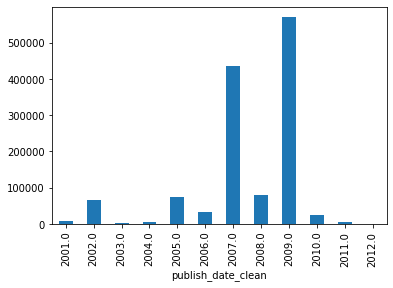

In [17]:
maps_gdf.groupby(maps_gdf['publish_date_clean'].dt.year).count()['year'].plot(kind='bar')

In [ ]:
print(maps_gdf.shape)
maps_gdf.head()

In [18]:
%%time
maps_gdf.to_file('../data/input/hazard_maps/hazard_maps.geojson', driver='GeoJSON')

CPU times: user 11min 3s, sys: 20.7 s, total: 11min 24s
Wall time: 11min 46s
